In [1]:
import xarray as xr
import numpy as np
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
import imageio.v2 as imageio
import numpy as np
import sparse

## reading the annual data with monthly values (converted using ncrcat)

In [14]:
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2809_default2080/All_NSSP534frc2esm_f19_tn14_2809_default2080.clm2.h1.2080-2083.nc'      #default
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/All_NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2080_2083.nc'   #sugarcane

#file1='/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1008_withrestart/lnd/hist/All_NSSP534frc2esm_f19_tn14_1008_withrestart.clm2.h1.2080.nc'

#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2080_all.nc'   #sugarcane
file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/All_NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2080-2083.nc' #sugarcane
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2083_all.nc'   #sugarcane

#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2809_default2080/lnd/hist/NSSP534frc2esm_f19_tn14_2809_default2080.clm2.h1.2080_all.nc'      #default

#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2080_all.nc'   #sugarcane
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2081_all.nc'   #sugarcane
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2082_all.nc'   #sugarcane
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2083_all.nc'   #sugarcane
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2009_sugarcane_restart2060/lnd/NSSP534frc2esm_f19_tn14_2009_sugarcane_restart2060.clm2.h1.2060_all.nc'   #sugarcane 2060
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2009_sugarcane_restart2040/lnd/NSSP534frc2esm_f19_tn14_2009_sugarcane_restart2040.clm2.h1.2040_all.nc'   #sugarcane 2040
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2109_sugarcane_emission2040/lnd/NSSP534frc2esm_f19_tn14_2109_sugarcane_emission2040.clm2.h1.2080_all.nc'   #sugarcane 2080 with 2040 emissions
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_2109_sugarcane_emission2060/lnd/NSSP534frc2esm_f19_tn14_2109_sugarcane_emission2060.clm2.h1.2080_all.nc'   #sugarcane 2080 with 2060 emissions
#file1 = '/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0509_sugarcane/lnd/hist/pp_h1/2083/NPP_NSSP534frc2esm_f19_tn14_0509_sugarcane.clm2.h1.2082.all.nc'
data = xr.open_dataset(file1, decode_times=False)
#data_corn= xr.open_dataset(files_corn, decode_times=False)
#data_sgrass= xr.open_dataset(files_switchgrass, decode_times=False)
#data_objects = [data, data_corn, data_sgrass]  # List of your data objects

for var_name in data.variables:
        if data[var_name].dtype == 'int32':
            data[var_name] = data[var_name].astype('float64')

In [15]:
pft_constants = xr.open_dataset("/cluster/shared/noresm/inputdata/lnd/clm2/paramdata/clm5_params.c171117.nc")
pftnames = pft_constants.pftname

##Functions to convert 

In [18]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

In [19]:
sparse_data = convert_pft_variables_to_sparse(data, pftnames)

Format,coo
Data Type,float64
Shape,"(12, 79, 96, 144)"
nnz,2394420
Density,0.18270829670651664
Read-only,True
Size,91.3M
Storage ratio,0.9


##write the gridded data directly to an nc file

In [35]:
selected_vegtypes = [67,68]
NPP_cane =(sparse_data.NPP.isel(vegtype=selected_vegtypes)*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes)).sum('vegtype') 
NPP_cane_nc = NPP_cane.as_numpy()
NPP_cane_nc = xr.where(NPP_cane_nc >= 0, NPP_cane_nc, 0)
NPP_cane_nc
NPP_cane_nc.name= "NPP"
NPP_cane_nc.attrs['units'] = "gC/m^2/s"
NPP_cane_nc.attrs['cell_methods'] = "time: mean"
NPP_cane_nc.attrs['_FillValue'] = 1.e+36
NPP_cane_nc.attrs['missing_value'] = 1.e+36
NPP_cane_nc.attrs['long_name'] = "net primary production"

NPP_cane_nc.to_netcdf('/cluster/projects/nn9576k/anusha/DATA/NPP_sugarcanelandusesimulation_clm2_h1_gridded_2080-2083_corrected.nc', mode='w', format='NETCDF4')

##If needed, add times and take annual sum

In [22]:
NPP_cane_nc
start_date1 = '2080-01'
end_date1   = '2084-01'
time2 = pd.date_range(start=start_date1, end=end_date1, freq='M')
len(time2)
NPP_cane_nc=NPP_cane_nc.assign_coords(time=time2)
NPP_cane_nc

annualsum_NPP = NPP_cane_nc.resample(time='AS').sum(dim='time')

In [29]:
annualsum_NPP

<xarray.DataArray 'NPP' (time: 4, lat: 96, lon: 144)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * time     (time) datetime64[ns] 2080-01-01 2081-01-01 2082-01-01 2083-01-01
Attributes:
    units:          gC/m^2/s
    cell_methods:   time: mean
    _FillValue:     1e+36
    missing_value:  1e+36
    long_name:      net primary production

##NPP from sugarcane

In [33]:
NPP_2080 = sparse_data.NPP.isel(time=slice(12, 24))

Format,coo
Data Type,float64
Shape,"(12, 79, 96, 144)"
nnz,2394420
Density,0.18270829670651664
Read-only,True
Size,91.3M
Storage ratio,0.9


In [34]:
#annualsum_NPP = sparse_data.NPP.resample(time='AS').sum(dim='time')
selected_vegtypes = [67,68]
NPP_sum_gC_year_cane =(NPP_2080.isel(vegtype=selected_vegtypes)*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes)).sum(['time', 'vegtype']) * (86400 * 30.5)  # Convert monthly npp in gC/m²/sec to gC/m²/year and summed over the year

NPP_sum_GtC_year_cane=NPP_sum_gC_year_cane*(1e-15)*data.area*(1e6) #gC/m²/year to GtC/year

NPP_sum_GtC_year_cane.sum(['lat','lon'])

<xarray.DataArray ()>
array(7.12841195)

In [38]:
NPP_sum_GtC_year_cane

<xarray.DataArray (lat: 96, lon: 144)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

##testing the NPP only from added sugarcane

In [43]:
file_weights = '/cluster/projects/nn9576k/anusha/DATA/weights_sugarcane_NPP_2030-2100_mod.nc'
dset_W = xr.open_dataset(file_weights, decode_times=False)
start_date = '2030'
end_date   = '2101'
years = pd.date_range(start=start_date, end=end_date, freq='A')
dset_W = dset_W.assign_coords(time=years)
weights=dset_W.weights.sel(time='2081')
#weights=dset_W.weights.sel(time=desired_year)
NPP_cane=np.multiply(NPP_sum_GtC_year_cane,weights)

In [45]:
NPP_cane.sum(['lat','lon'])

<xarray.DataArray (time: 1)>
array([4.25588318])
Coordinates:
  * time     (time) datetime64[ns] 2081-12-31

## calculate Sum and mean in gC/m2/s and GtC/year only for tropical corn

In [15]:
selected_vegtypes = [17,18,75,76]
NPP_sum_gC_year_corn =sparse_data.NPP.isel(vegtype=selected_vegtypes).sum(['time', 'vegtype']) * (86400 * 30)  # Convert monthly npp in gC/m²/sec to gC/m²/year and summed over the year
#NPP_mean_gC_year =sparse_data.NPP.mean('time').isel(vegtype=selected_vegtypes).sum('vegtype') * (86400 * 30)   # Convert monthly npp in gC/m²/sec to gC/m²/year and summed over the year

NPP_sum_GtC_year_corn=NPP_sum_gC_year_corn*(1e-15)*data.area*(1e6)*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes).sum('vegtype')  #gC/m²/year to GtC/year
#NPP_mean_GtC_year=NPP_mean_gC_year*(1e-15)*data.area*(1e6)*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes).sum('vegtype')

#NPP_sum_GtC_year=sparse_data.NPP.isel(vegtype=selected_vegtypes).sum(['time', 'vegtype'])*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes).sum('vegtype')*(1e-15)* (86400 * 30)
#NPP_mean_GtC_year=(sparse_data.NPP.mean('time').isel(vegtype=selected_vegtypes).sum('vegtype')*sparse_data.pfts1d_wtgcell.isel(vegtype=selected_vegtypes).sum('vegtype'))*(1e-15)* (86400 * 30)
#sparse_data.area

In [144]:
#print(np.sum(NPP_sum_GtC_year_corn))
print(np.sum(NPP_sum_GtC_year_cane))

<xarray.DataArray 'NPP' ()>
array(1.65071837e-09)


Format,coo
Data Type,float64
Shape,"(96, 144)"
nnz,2105
Density,0.15227141203703703
Read-only,True
Size,49.3K
Storage ratio,0.5


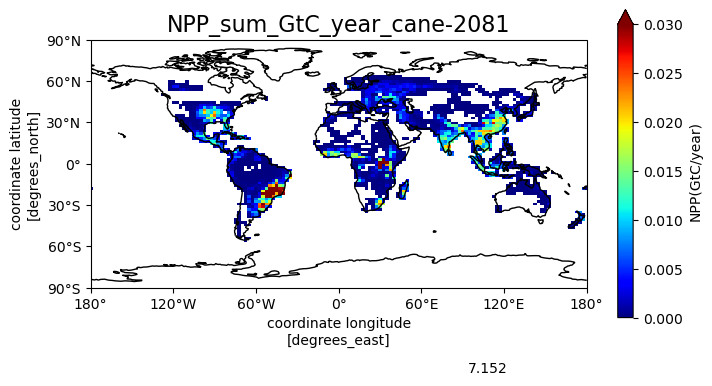

In [19]:
#NPP_sum_GtC_year_corn = NPP_sum_GtC_year_corn.where(NPP_sum_GtC_year_corn != 0)
#NPP_sum_GtC_year_cane= NPP_sum_gC_year_cane.where(NPP_sum_gC_year_cane != 0)


variables = ['NPP_sum_GtC_year_cane'] #'NPP_sum_GtC_year_corn',

for variable in variables:
    # Access the data for the current variable
    data = globals()[variable]  # Assuming the variables are defined in the global scope
    data = data.where(data > 0)
    fig, axs = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    xr.set_options(cmap_sequential=plt.cm.YlGn, keep_attrs=True)
    cmap = plt.cm.get_cmap()
    cmap.set_under('gray')
    cmap = plt.get_cmap('jet',)
    data.plot(cmap=cmap,vmin=0,vmax=0.03,cbar_kwargs={'label': 'NPP(GtC/year)'})

    land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='none', facecolor='white')
    axs.add_feature(land, zorder=0)
    axs.coastlines(linewidth=1)
    axs.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs.xaxis.set_major_formatter(lon_formatter)
    axs.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs.yaxis.set_major_formatter(lat_formatter)
    axs.set_title(f'{variable}-2081', fontsize=16, loc='center')
    annual_yield = (np.sum(data)).item()
    axs.text(0.8, -0.3, f"{annual_yield:.3f}", fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
    fig.patch.set_facecolor('white')
    plt.show()

Text(0.5, 1.0, 'NPP annualmean_t.corn(gC/m2/year)')

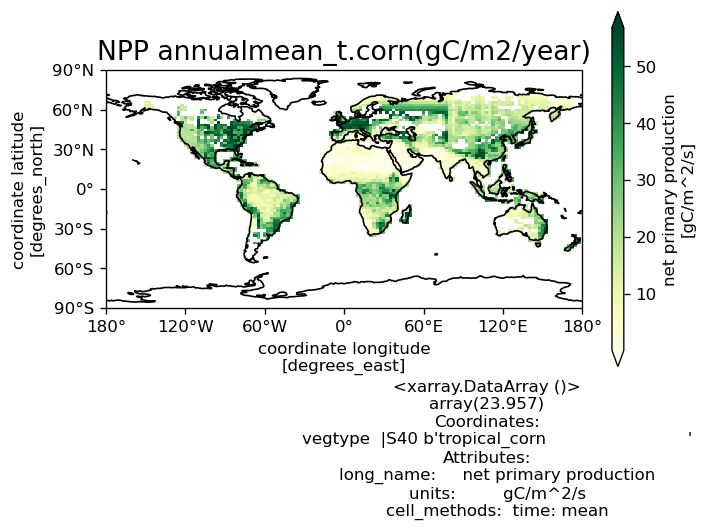

In [48]:

# some nice plotting settings
xr.set_options(cmap_sequential=plt.cm.YlGn, keep_attrs=True)
plt.rcParams["figure.dpi"] = 120
cbar_kwargs = {"orientation": "vertical", "shrink": 0.8, "aspect": 30}


def setup_axes():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    return ax
ax = setup_axes()
#NPP_year.isel(vegtype=75).sum('time').plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)
NPP_year_mean.plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)

ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter) 
annualyield_def = (np.sum(np.multiply(NPP_year_mean, sparse_data_sgrass.pfts1d_wtgcell.isel(vegtype=75))/(np.sum(sparse_data_sgrass.pfts1d_wtgcell.isel(vegtype=75)))))
ax.text(0.8, -0.3, annualyield_def.sum().round(3), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes); 
ax.set_title('NPP annualmean_t.corn(gC/m2/year)', fontsize=16, loc='center')  

Text(0.5, 1.0, 'NPP annualmean_t.corn(GtC/year)')

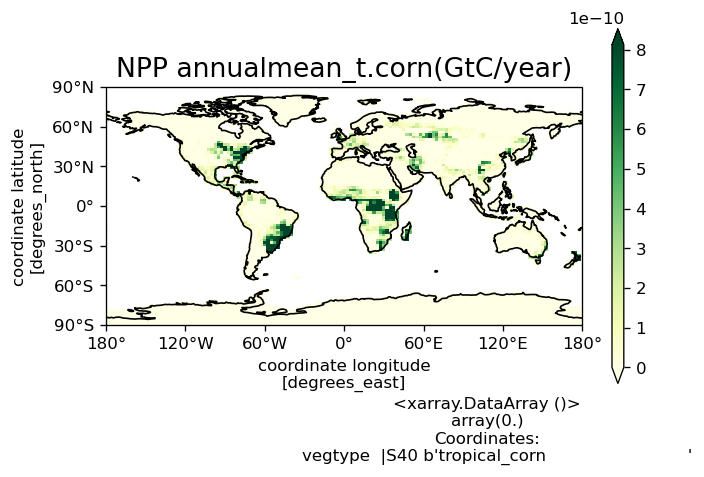

In [45]:

# some nice plotting settings
xr.set_options(cmap_sequential=plt.cm.YlGn, keep_attrs=True)
plt.rcParams["figure.dpi"] = 120
cbar_kwargs = {"orientation": "vertical", "shrink": 0.8, "aspect": 30}


def setup_axes():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    return ax
ax = setup_axes()
#NPP_year.isel(vegtype=75).sum('time').plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)
NPP_GtCperyear.isel(vegtype=75).plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)

ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter) 
annualyield_def = (np.sum(np.multiply(NPP_GtCperyear.isel(vegtype=75), sparse_data_sgrass.pfts1d_wtgcell.isel(vegtype=75))/(np.sum(sparse_data_sgrass.pfts1d_wtgcell.isel(vegtype=75)))))
ax.text(0.8, -0.3, annualyield_def.sum().round(3), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes); 
ax.set_title('NPP annualmean_t.corn(GtC/year)', fontsize=16, loc='center')  


##read monthly data

In [ ]:
list_files_def = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1008_withrestart/lnd/hist/NSSP534frc2esm_f19_tn14_1008_withrestart.clm2.h1.2080*.nc")
list_files_corn = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0908_withrestart_withmodlanduse2/lnd/hist/NSSP534frc2esm_f19_tn14_0908_withrestart_withmodlanduse2.clm2.h1.*.nc")
#list_files_switchgrass = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1008_withrestart_withswitchgrass/lnd/hist/NSSP534frc2esm_f19_tn14_1008_withrestart_withswitchgrass.clm2.h1.*.nc")
#list_files_corn_nofert = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1408_withrestart_testsrcfiles/lnd/hist/NSSP534frc2esm_f19_tn14_1408_withrestart_testsrcfiles.clm2.h1.*.nc")

list_files_def = sorted(list_files_def)
list_files_corn = sorted(list_files_corn)
#list_files_switchgrass = sorted(list_files_switchgrass)

size_iteration = len(list_files_def)
size_iteration1 = len(list_files_corn)
#size_iteration3 = len(list_files_switchgrass)

print(size_iteration)
print(size_iteration1)
#print(size_iteration3)
#variables = ['CPHASE','GDDHARV','GDDPLANT']                            # h2 and h3 files
variables = ['GRAINC_TO_FOOD','GRAINN','GRAINC','NPP','WOODC']         # h0 and h1 files
results_def= np.zeros((len(variables), (size_iteration)))
results_corn = np.zeros((len(variables), (size_iteration)))
results_sgrass = np.zeros((len(variables), (size_iteration)))
results3 = np.zeros((size_iteration))

##combine the monthly dataset

In [ ]:
import xarray as xr

# Initialize an empty list to store dataset objects from each file
dataset_list = []

# Loop through the files
for i in range(size_iteration):
    # Read the dataset from the current file
    dset = xr.open_dataset(list_files_def[i], decode_times=False)
    
    # Append the dataset to the list
    dataset_list.append(dset)

# Combine the list of dataset objects into a single dataset, overriding conflicting attributes
data = xr.combine_by_coords(dataset_list, combine_attrs='override')

# You can access the entire combined dataset with all variables, including NPP, like this:
# combined_dataset['NPP']


In [4]:
npp_global_means_def = []
npp_global_means_corn_mod =[]
for i in range(size_iteration):
    #print(i)
    dset2_def = xr.open_dataset(list_files_def[i], decode_times=False)
    npp_def = dset2_def['NPP'].values
    p1d_i_def = dset2_def['pfts1d_itype_veg'].values
    corn_def = np.where(p1d_i_def == 75)
    npp_glob = np.nanmean(npp_def[:, corn_def])
    npp_global_means_def.append(npp_glob)

    dset2_corn = xr.open_dataset(list_files_corn[i], decode_times=False)
    npp_corn = dset2_corn['NPP'].values
    p1d_i_corn = dset2_corn['pfts1d_itype_veg'].values
    corn_mod = np.where(p1d_i_corn == 75)
    npp_glob_corn = np.nanmean(npp_corn[:, corn_mod])
    npp_global_means_corn_mod.append(npp_glob_corn)

#npp_global_means_def
#npp_global_means_corn_mod

[5.73658637021427e-06,
 1.1692432412162492e-06,
 1.7396242627254161e-06,
 1.111370098217246e-05,
 1.0012636765942314e-05,
 1.1042682315477529e-05,
 3.5797215272244265e-06,
 1.2356154121737289e-06,
 1.581554412099568e-06,
 1.2789852828125749e-05,
 1.1749991648152294e-05,
 1.1307636106054695e-05,
 5.638830601229739e-06,
 1.1421721546467688e-06,
 1.5131653242686058e-06,
 1.2324746527980154e-05,
 1.1712265542840408e-05,
 1.1998301338004621e-05,
 4.5388282018244085e-06,
 1.0885675343253157e-06,
 1.674959114307713e-06,
 1.399903016167644e-05,
 1.1821805929887787e-05,
 1.0884238452483717e-05,
 5.5508732082718144e-06,
 1.1686208493831463e-06,
 1.7300484034442979e-06,
 1.1511022004455907e-05,
 1.0853593315171532e-05,
 1.0850405845601657e-05,
 3.354521798256397e-06,
 1.1934194684533157e-06,
 1.6875064208520814e-06,
 1.3315208843807559e-05,
 1.2227828968400187e-05,
 1.1438187979490414e-05,
 5.470587767055606e-06,
 1.1690393540662788e-06,
 1.5862763097562199e-06,
 1.2197744899458051e-05,
 1.117029

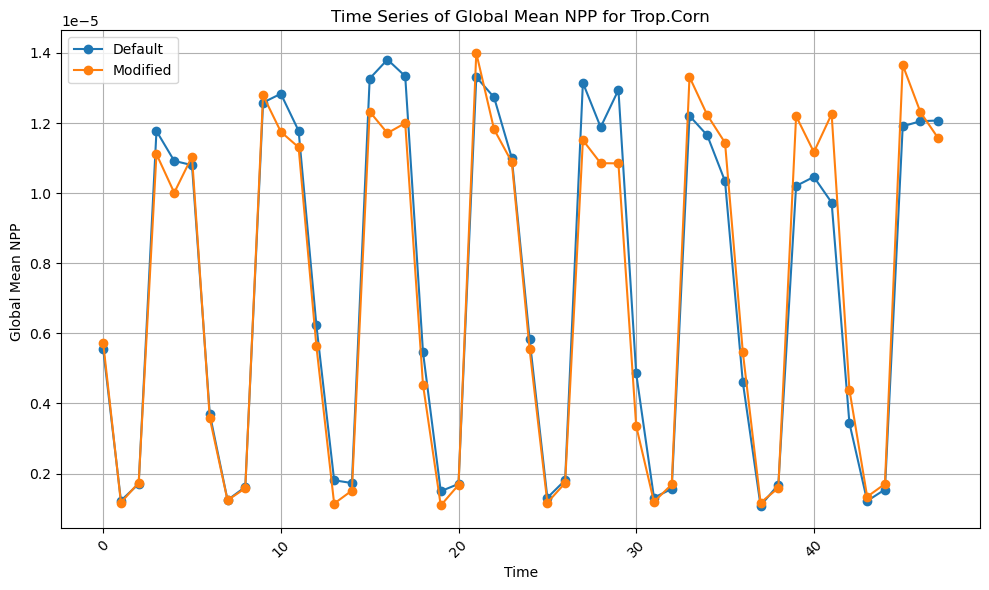

In [7]:
npp_global_means_def = np.array(npp_global_means_def)
npp_global_means_corn_mod = np.array(npp_global_means_corn_mod)
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(npp_global_means_def, marker='o', linestyle='-',label='Default')
plt.plot(npp_global_means_corn_mod, marker='o', linestyle='-',label='Modified')
plt.xlabel('Time')
plt.ylabel('Global Mean NPP ')
plt.title('Time Series of Global Mean NPP for Trop.Corn')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


# Show the plot
plt.show()


In [16]:
# Initialize lists to store results
months = []
npp_global_means = []
# Loop through the monthly files
for file_path in list_files_def:
    # Open the NetCDF dataset
    ds = xr.open_dataset(file_path)
    # Extract 'NPP' and 'pfts1d_itype_veg' variables as NumPy arrays
    npp = ds['NPP'].values
    p1d_i = ds['pfts1d_itype_veg'].values
    # Find indices where 'pfts1d_itype_veg' is equal to 75
    corn = np.where(p1d_i == 75)
    #sugarcane = np.where(p1d_i == 67)
    #switchgrass = np.where(p1d_i == 67)
    # Calculate the global mean of 'NPP' values where 'pfts1d_itype_veg' is 75
    npp_glob = np.nanmean(npp[:, corn])
    # Access the 'time' variable
    time_variable = ds['time']
    # Append results to lists
    months.append(time_variable.values)
    npp_global_means.append(npp_glob)
    
    # Close the dataset
    ds.close()
months.append(np.concatenate(months))
npp_global_means

[5.5636100997467534e-06,
 1.2261037038330975e-06,
 1.7061658442569814e-06,
 1.17718725915295e-05,
 1.0919642166009379e-05,
 1.0799058341772044e-05,
 3.7009543003664646e-06,
 1.2440512064510856e-06,
 1.6166289365221848e-06,
 1.2584003823004718e-05,
 1.283493554112204e-05,
 1.1778482440478366e-05,
 6.234321017368773e-06,
 1.8080638326339952e-06,
 1.7275729374792434e-06,
 1.3268045351506185e-05,
 1.3811301554250741e-05,
 1.3337211697696693e-05,
 5.466004118425514e-06,
 1.495321246406405e-06,
 1.7027331578871126e-06,
 1.3310096587412086e-05,
 1.2735060889779707e-05,
 1.099922406137594e-05,
 5.835540670016472e-06,
 1.3082645346414247e-06,
 1.8098780637731738e-06,
 1.3149417596459778e-05,
 1.1881347754825572e-05,
 1.2944611793365089e-05,
 4.8551582472742874e-06,
 1.3135265699165868e-06,
 1.5594815560465335e-06,
 1.2205622791592576e-05,
 1.1649139986111251e-05,
 1.034021022722846e-05,
 4.6114904056712495e-06,
 1.083694620954774e-06,
 1.6808979352081601e-06,
 1.020534252740485e-05,
 1.04636373

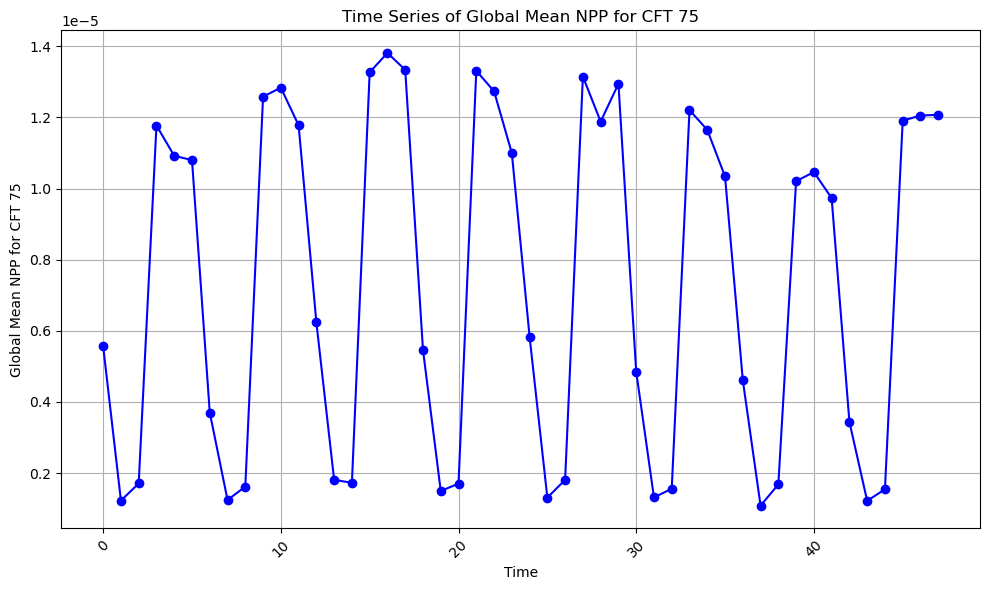

array([5.56361010e-06, 1.22610370e-06, 1.70616584e-06, 1.17718726e-05,
       1.09196422e-05, 1.07990583e-05, 3.70095430e-06, 1.24405121e-06,
       1.61662894e-06, 1.25840038e-05, 1.28349355e-05, 1.17784824e-05,
       6.23432102e-06, 1.80806383e-06, 1.72757294e-06, 1.32680454e-05,
       1.38113016e-05, 1.33372117e-05, 5.46600412e-06, 1.49532125e-06,
       1.70273316e-06, 1.33100966e-05, 1.27350609e-05, 1.09992241e-05,
       5.83554067e-06, 1.30826453e-06, 1.80987806e-06, 1.31494176e-05,
       1.18813478e-05, 1.29446118e-05, 4.85515825e-06, 1.31352657e-06,
       1.55948156e-06, 1.22056228e-05, 1.16491400e-05, 1.03402102e-05,
       4.61149041e-06, 1.08369462e-06, 1.68089794e-06, 1.02053425e-05,
       1.04636373e-05, 9.73075958e-06, 3.43931133e-06, 1.21826583e-06,
       1.54359836e-06, 1.19071851e-05, 1.20525786e-05, 1.20720541e-05])

In [6]:
# Convert lists to arrays
#months = months.append(np.concatenate(months))
npp_global_means = np.array(npp_global_means)
npp_global_means
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(npp_global_means, marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Global Mean NPP for CFT 75')
plt.title('Time Series of Global Mean NPP for CFT 75')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
npp_global_means

In [131]:
npp_glob

1.2261037038330975e-06

In [6]:

# Open the NetCDF dataset
ds = xr.open_dataset('/cluster/shared/noresm/inputdata/mdeb/NSSP534frc2esm_f19_tn14_1008_withrestart.clm2.h1.2080-02.nc')

# Extract 'NPP' and 'pfts1d_itype_veg' variables as NumPy arrays
npp = ds['NPP'].values
p1d_i = ds['pfts1d_itype_veg'].values

# Find indices where 'pfts1d_itype_veg' is equal to 75
cft61 = np.where(p1d_i == 75)

# Calculate the global mean of 'NPP' values where 'pfts1d_itype_veg' is 75
npp_glob = np.nanmean(npp[:, cft61])

# Access the 'time' variable
npp_glob
p1d_i

array([0, 1, 2, ..., 0, 0, 0], dtype=int32)

In [116]:
#list_files_def = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1605/lnd/hist/NSSP534frc2esm_f19_tn14_1605.clm2.h4.*.nc")
list_files_def = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1008_withrestart/lnd/hist/NSSP534frc2esm_f19_tn14_1008_withrestart.clm2.h1.*.nc")
list_files_corn = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_0908_withrestart_withmodlanduse2/lnd/hist/NSSP534frc2esm_f19_tn14_0908_withrestart_withmodlanduse2.clm2.h1.*.nc")
#list_files_switchgrass = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1008_withrestart_withswitchgrass/lnd/hist/NSSP534frc2esm_f19_tn14_1008_withrestart_withswitchgrass.clm2.h1.*.nc")
#list_files_corn_nofert = glob.glob("/cluster/work/users/a2021/archive/NSSP534frc2esm_f19_tn14_1408_withrestart_testsrcfiles/lnd/hist/NSSP534frc2esm_f19_tn14_1408_withrestart_testsrcfiles.clm2.h1.*.nc")

list_files_def = sorted(list_files_def)
list_files_corn = sorted(list_files_corn)
#list_files_switchgrass = sorted(list_files_switchgrass)

size_iteration = len(list_files_def)
size_iteration1 = len(list_files_corn)
#size_iteration3 = len(list_files_switchgrass)

print(size_iteration)
print(size_iteration1)
#print(size_iteration3)
variables = ['CPHASE','GDDHARV','GDDPLANT']
results_def= np.zeros((len(variables), (size_iteration)))
results_corn = np.zeros((len(variables), (size_iteration)))
results_sgrass = np.zeros((len(variables), (size_iteration)))
results3 = np.zeros((size_iteration))

48
48


In [3]:
dset2_def = xr.open_dataset(list_files_def[1], decode_times=False)
type(dset2_def['NPP'])
npp = dset2_def['NPP']

p1d_i=dset2_def['pfts1d_itype_veg']
npp = dset2_def['NPP'].to_numpy()
p1d_i=dset2_def['pfts1d_itype_veg']
p1d_i=p1d_i.to_numpy()
cft61= np.where(p1d_i==61)
dset2_def



<xarray.Dataset>
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 25, time: 1,
                         hist_interval: 2, lon: 144, lat: 96, gridcell: 5701,
                         landunit: 17795, column: 142368, pft: 222182)
Coordinates:
  * levgrnd             (levgrnd) float64 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak              (levlak) float64 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.77
  * levdcmp             (levdcmp) float64 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) float64 59.0
  * lon                 (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Dimensions without coordinates: hist_interval, gridcell, landunit, column, pft
Data variables: (12/87)
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    time_bounds         (time, hist_interval) float64 ...
    ...                  ...
    TOTECOSYSN          (time, column) float64 ...
    TOTSOMC             (time, column) float64 ...
    TOTSOMN             (time, column) float64 ...
    TOTVEGC             (time, pft) float64 ...
    TOTVEGN             (time, pft) float64 ...
    WOODC               (time, pft) float64 ...
Attributes: (12/102)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 16:13:31
    source:                                    Community Land Model CLM4.0
    hostname:                                  betzy
    ...                                        ...
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./NSSP534frc2esm_f19_tn14_1008...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

 ...]

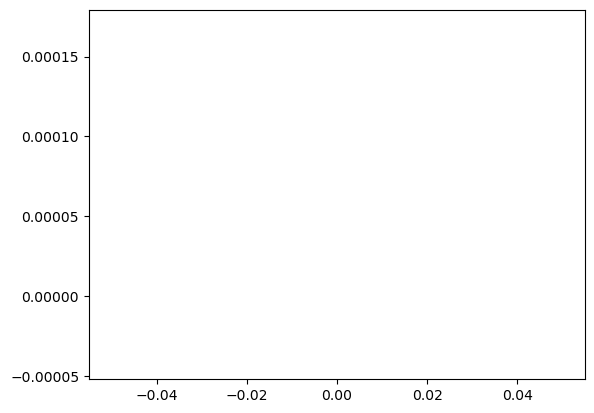

In [125]:
#glob_mean_npp61=np.nanmean(npp[:,cft61],1)
#glob_mean_npp61
plt.plot(npp)

In [97]:
dset2_def = xr.open_dataset(list_files_def[1], decode_times=False)
NPP=dset2_def['NPP']*dset2_def['pfts1d_wtgcell']

NPP_total =NPP*dset2_def['area']*dset2_def['landfrac']
#NPP_total.sel(pft=52).plot()
dset2_def['pfts1d_itype_veg'] #pft vegetation type

pfts1d_tropical_corn = np.where(dset2_def['pfts1d_itype_veg'] == 61)[0]
count = len(pfts1d_tropical_corn)

print("Number of values satisfying the condition:", count)


Number of values satisfying the condition: 5701


In [103]:
darr2_def = dset2_def.to_array(dim='vars')
#darr2_def.dims

ValueError: iterator is too large

IndexError: index 27 is out of bounds for axis 0 with size 1

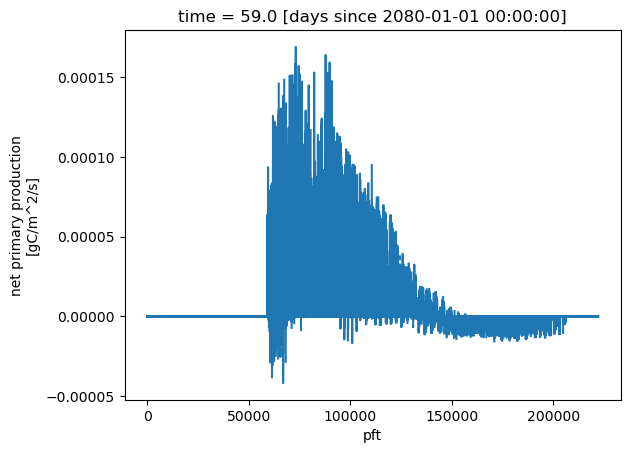

In [96]:
#npp_ave_tropical_crop=np.mean(dset2_def['NPP'][pfts1d_tropical_corn],axis=1)
dset2_def['NPP'].plot()
#pfts1d_tropical_corn
filtered_npp =dset2_def['NPP'][pfts1d_tropical_corn]

In [ ]:
filtered NPP

In [71]:
dset2_def
print(len(np.where(dset2_def['pfts1d_itype_veg']==61)))
#print(len((dset2_def['pfts1d_itype_veg'])))
print(type(dset2_def['pfts1d_itype_veg']))

1
<class 'xarray.core.dataarray.DataArray'>


In [77]:
total_length = len(dset2_def['pfts1d_itype_veg'])
print("Total length of the array:", total_length)

# Count occurrences of a particular value (e.g., value = 61)
target_value = 61
count_of_target_value = np.count_nonzero(dset2_def['pfts1d_itype_veg'] == target_value)
print(f"Number of occurrences of value {target_value}: {count_of_target_value}")

Total length of the array: 222182
Number of occurrences of value 1: 5701


In [6]:

# store in "results"
for i in range(size_iteration):
    #print(i)
    dset2_def = xr.open_dataset(list_files_def[i], decode_times=False)
    dset2_corn = xr.open_dataset(list_files_corn[i], decode_times=False)
    time_def = dset2_def['time']
    #dset2_switchgrass = xr.open_dataset(list_files_switchgrass[i], decode_times=False)
    for j in range(len(variables)):
        results_def[j, i] = dset2_def[variables[j]].sum(['lat','lon']).mean('time')
        results_corn[j, i] = dset2_corn[variables[j]].sum(['lat','lon']).mean('time')
        #results_sgrass[j, i] = dset2_switchgrass[variables[j]].sum(['lat','lon'])


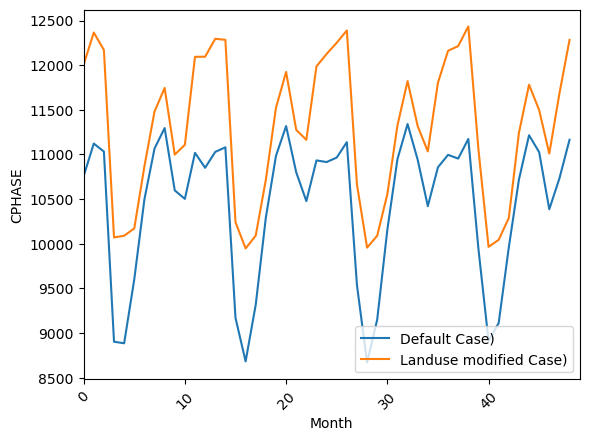

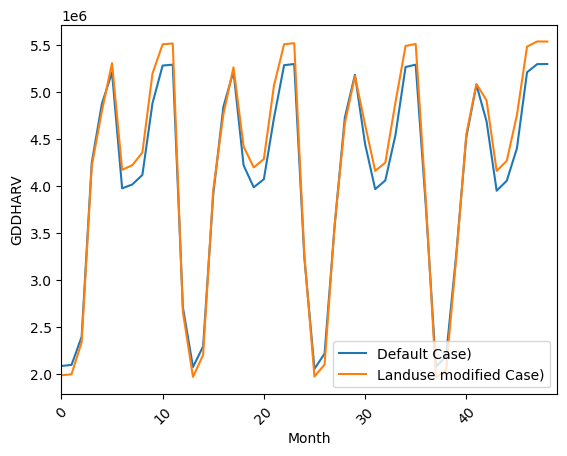

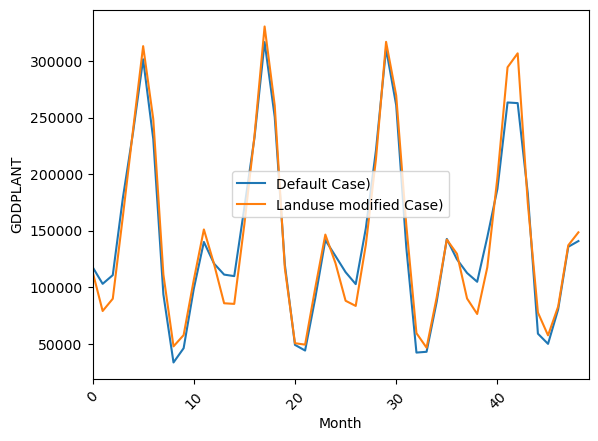

In [7]:
# plot
for k in range(len(variables)):
    fig, ax = plt.subplots()
    #plt.plot(results[k], label='No shipping (control)')
    plt.plot(results_def[k], label='Default Case)')
    plt.plot(results_corn[k], label='Landuse modified Case)')
    #print(results2[k] / results[k])
    plt.xlim(0,size_iteration)
    plt.xlabel('Month')
    plt.ylabel(variables[k])
    plt.legend()
    #plt.savefig(variables[k]+'.png')
    # Format x-axis labels as year-month
    plt.xticks(rotation=45)
 

In [11]:
sum_cropyield_def=0
sum_cropyield_corn=0
sum_cropyield_sgrass=0
for i in range(size_iteration):
    dset_case_def = xr.open_dataset(list_files_def[i], decode_times=False)
    dset_case_corn = xr.open_dataset(list_files_corn[i], decode_times=False)
    
    sum_cropyield_def=dset_case_def['GDDHARV'].mean(['time'])
    sum_cropyield_corn=dset_case_corn['GDDHARV'].mean(['time'])

    #sum_cropyield +=cropyield  
Grain_yield_def= (sum_cropyield_def)#*(0.85/0.45)*86400*30)/100 # converting to crop yield in gC/m2
Grain_yield_corn= (sum_cropyield_corn)#*(0.85/0.45)*86400*30)/100 # converting to crop yield in gC/m2



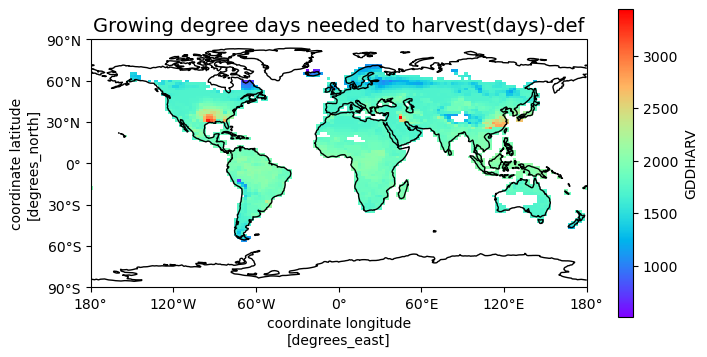

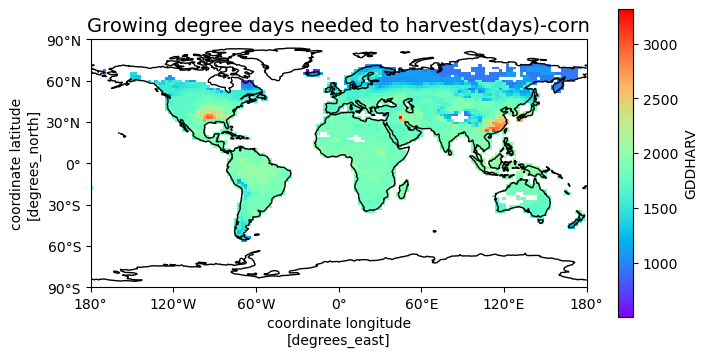

In [17]:

fig, axs = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.cm.get_cmap('rainbow')
cmap.set_under('gray')
Grain_yield_def.plot(cmap=cmap)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='none',facecolor='white')
axs.add_feature(land, zorder=0)
axs.coastlines(linewidth=1)
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter) 
axs.set_title('Growing degree days needed to harvest(days)-def', fontsize=14, loc='center')      

plt.show()

fig, axs = plt.subplots(figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.cm.get_cmap('rainbow')
cmap.set_under('gray')
Grain_yield_corn.plot(cmap=cmap)
land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='none',facecolor='white')
axs.add_feature(land, zorder=0)
axs.coastlines(linewidth=1)
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter) 
axs.set_title('Growing degree days needed to harvest(days)-corn', fontsize=14, loc='center')      

plt.show()